In [44]:
import numpy as np
import pickle
import itertools
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import transforms
from SegDataset import SegmentationDataset
from einops import rearrange
from transformers import AdamW, SegformerForSemanticSegmentation, SegformerConfig
import matplotlib.pyplot as plt
import random

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.data import DataLoader

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Config

In [46]:
DATASET_DIRECTORY = "ml-mangrove-data/"
#PRETRAINED_MODEL_NAME = "nvidia/mit-b5"
PRETRAINED_MODEL_NAME = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024" #alternative pretrained_model_name = "nvidia/mit-b0"
#PRETRAINED_MODEL_NAME ="./segformer-b3-finetuned-mangrove-128-128-15p/" 


DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #device to be used for training and evaluation
PIN_MEMORY = True if DEVICE == "cuda" else False #if we will be pinning memory during data loading

INPUT_IMAGE_WIDTH = 128 #or 256
INPUT_IMAGE_HEIGHT = 128
NUM_CHANNELS = 9
NUM_CLASSES = 1

TEST_SPLIT = 0.10
PERCENT_NOMANGROVE_TILE_KEEP = 0.15 #percent of empty mangrove tiles to keep
BATCH_SIZE = 32
INIT_LR = 0.0002 #0.0001 #0.00006
# LOSS_FUNCTION = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0, 1.0]))
NUM_EPOCHS = 30
TEST_EVAL_EVERY_BATCH = 1 #how frequently to compute/save/display test accuracy, must be non-zero positive

EARLY_STOPPER_PATIENCE = 3 #how many epochs of lower test set accuracy before early stopping (also dependent on delta)
EARLY_STOPPER_DELTA = 0 #how much test set accuracy needs to drop before early stopping (also dependent on patience)

Read Files

In [47]:
#read data from https://www.kaggle.com/datasets/stanleydil/e4e-jamaica-segmentation-dataset by read from kaggle
with open(DATASET_DIRECTORY + '128px_images.pkl', 'rb') as handle:
    images = pickle.load(handle)

with open(DATASET_DIRECTORY + '128px_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

with open(DATASET_DIRECTORY + '128_mlabels.pkl', 'rb') as handle:
    m_tiles = pickle.load(handle)

Data Preprocessing

In [48]:
#rearrange dimensions of images and labels
images = np.array(images)
images = rearrange(images, "b w h c -> b c w h")

labels = np.array(labels)
labels = rearrange(labels, "b w h c -> b c w h")
labels = np.squeeze(labels, axis=1)

print(f'input shape (b x c x w x h): {images.shape}')
print(f'label shape (b x [squeezed 1 channel] x w x h): {labels.shape}')

input shape (b x c x w x h): (4092, 9, 128, 128)
label shape (b x [squeezed 1 channel] x w x h): (4092, 128, 128)


In [49]:
# images = np.concatenate((images[:750], images[1000:]), axis=0)
# labels = np.concatenate((labels[:750], labels[1000:]), axis=0)

trainImages, testImages, trainMasks, testMasks = train_test_split(images, labels,
                         test_size=TEST_SPLIT, random_state=42)

#systemic undersampling of 0 class
mask_sums = trainMasks.sum(axis=(1, 2))
non_empty_indices = mask_sums > 0

non_empty_indices_ls = non_empty_indices.tolist()
non_empty_indices = []
for element in non_empty_indices_ls:
    if element == False:
        if random.random() < PERCENT_NOMANGROVE_TILE_KEEP:
            non_empty_indices.append(True)
        else:
            non_empty_indices.append(False)
    else:
          non_empty_indices.append(True)

trainImages = trainImages[non_empty_indices]
trainMasks = trainMasks[non_empty_indices]


# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT,
                                                    INPUT_IMAGE_WIDTH)),
                                 transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks, transforms = transforms)
                              #transforms=transforms)
testDS = SegmentationDataset(images=testImages, labels=testMasks, transforms = transforms)
                             #transforms=transforms)
# testwithheldDS = SegmentationDataset(images=images[750:1000], labels=labels[750:1000], transforms = transforms)
#                              #transforms=transforms)

print(f"found {len(trainDS)} examples in the training set.")
print(f"found {len(testDS)} examples in the test set.")

# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=0) #os.cpu_count()
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=0) #os.cpu_count()
# testwithheldLoader = DataLoader(testwithheldDS, shuffle=False,
#                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
#                         num_workers=0) #os.cpu_count()

found 1401 examples in the training set.
found 410 examples in the test set.


In [50]:
# assign the human-readable labels to encoding, encoding to human-readable labels
id2label = {
    0: "nomangrove",
    1: "mangrove"
}

label2id = {
    "nomangrove": 0,
    "mangrove": 1
}

Initialize Model

In [51]:
# config = SegformerConfig.from_pretrained(PRETRAINED_MODEL_NAME)
# config.id2label = id2label
# config.label2id = label2id

# Load the pretrained model
model = SegformerForSemanticSegmentation.from_pretrained(
    PRETRAINED_MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_labels = 2,
    num_channels = 9
)

# Modify the first layer to match the number of channels in data
# modified_layer = nn.Conv2d(NUM_CHANNELS, 64, kernel_size=7, stride=4, padding=3)
# model.segformer.encoder.patch_embeddings[0].proj = modified_layer

In [52]:
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(9, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

Helper Classes

In [53]:
batch = next(iter(trainLoader))
test_batch = itertools.cycle(testLoader)
# val_batch = itertools.cycle(testwithheldLoader)

In [54]:
optimizer = AdamW(model.parameters(), lr=INIT_LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

Model Initialized!


/home/mpham/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [55]:
class Early_stopper: #early stopper class -> move to py file
    def __init__(self):
        self.patience = EARLY_STOPPER_PATIENCE
        self.delta = EARLY_STOPPER_DELTA
        self.patience_counter = 0
        self.min_test_loss = np.inf
    def check_stop(self, test_loss):
        if self.min_test_loss > test_loss:
            self.patience_counter = 0
            self.min_test_loss = test_loss
        elif test_loss > (self.min_test_loss + self.delta):
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
        return False

In [56]:
class Total_updater:
  def __init__(self):
    self.test_epoch = [] 
    self.test_acc = [] 
    self.test_avr_acc = [] 
    self.test_loss = [] 
    self.test_avr_loss = [] 
    self.test_avr_acc_epoch = []
    self.test_avr_loss_epoch = []
    self.tests_count = 0 
    self.tests_epoch_count = 0 

    self.train_epoch = []
    self.train_acc = []
    self.train_avr_acc = []
    self.train_loss = []
    self.train_avr_loss = []
    self.train_avr_acc_epoch = []
    self.train_avr_loss_epoch = []
    self.trains_count = 0
    self.trains_epoch_count = 0


    self.epoch_test_acc_cum = 0 #use
    self.total_test_acc_cum = 0 #use
    self.epoch_test_loss_cum = 0 #use
    self.total_test_loss_cum = 0 #use

    self.epoch_train_acc_cum = 0
    self.total_train_acc_cum = 0
    self.epoch_train_loss_cum = 0
    self.total_train_loss_cum = 0

    self.epoch = 0
  def update_test(self, acc, loss):
    self.tests_count += 1
    self.tests_epoch_count += 1
    self.test_epoch.append(self.epoch + TEST_EVAL_EVERY_BATCH * self.tests_epoch_count/(len(trainDS) // BATCH_SIZE + 1 ))#self.epoch + (self.tests_epoch_count-1)/self.tests_epoch_count)

    self.test_acc.append(acc)
    self.test_acc.append(loss)

    self.epoch_test_acc_cum += acc
    self.total_test_acc_cum += acc
    self.epoch_test_loss_cum += loss
    self.total_test_loss_cum += loss

    self.test_avr_acc.append(self.total_test_acc_cum/self.tests_count)
    self.test_avr_loss.append(self.total_test_loss_cum/self.tests_count)

  def update_train(self, acc, loss):
    self.trains_count += 1
    self.trains_epoch_count += 1
    self.train_epoch.append(self.epoch + self.trains_epoch_count/(len(trainDS) // BATCH_SIZE + 1 )) #(self.epoch + (self.trains_epoch_count-1)/self.trains_epoch_count)

    self.train_acc.append(acc)
    self.train_acc.append(loss)

    self.epoch_train_acc_cum += acc
    self.total_train_acc_cum += acc
    self.epoch_train_loss_cum += loss
    self.total_train_loss_cum += loss

    self.train_avr_acc.append(self.total_train_acc_cum/self.trains_count)
    self.train_avr_loss.append(self.total_train_loss_cum/self.trains_count)


  def reset_epoch(self):
    self.test_avr_acc_epoch.append(self.epoch_test_acc_cum/self.tests_epoch_count)
    self.test_avr_loss_epoch.append(self.epoch_test_loss_cum/self.tests_epoch_count)

    self.train_avr_acc_epoch.append(self.epoch_train_acc_cum/self.trains_epoch_count)
    self.train_avr_loss_epoch.append(self.epoch_train_loss_cum/self.trains_epoch_count)
    
    print(f"EPOCH {self.epoch} Avr Test Accuracy: {self.test_avr_acc_epoch[self.epoch]}\
         Avr Test Loss: {self.test_avr_loss_epoch[self.epoch]}\
         Avr Train Accuracy: {self.train_avr_acc_epoch[self.epoch]}\
         Avr Train Loss: {self.train_avr_loss_epoch[self.epoch]}")
    
    
    self.epoch_test_acc_cum = 0
    self.epoch_test_loss_cum = 0
    self.epoch_train_acc_cum = 0
    self.epoch_train_loss_cum = 0

    self.tests_epoch_count = 0
    self.trains_epoch_count = 0

    self.epoch += 1



In [57]:
early_stopper = Early_stopper()
total_updater = Total_updater()

Train

In [58]:
for epoch in range(NUM_EPOCHS):
    print("Epoch:", epoch)
    pbar = tqdm(trainLoader)
    model.train()
    
    total_train_set = []
    for idx, batch in enumerate(pbar):
        batch_index = idx

        # get the inputs
        pixel_values = batch[0].to(device)
        labels = batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        #train set eval
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        mask = (labels != -1) # don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss

        # probabilities = torch.sigmoid(upsampled_logits)
        # logits_flat = upsampled_logits.reshape(-1, 2)  # Reshape logits to [batch_size * height * width, num_classes]
        # labels_one_hot = nn.functional.one_hot(labels.view(-1), num_classes=2)
        # loss_fn = nn.BCEWithLogitsLoss().cuda()
        # loss = loss_fn(logits_flat, labels_one_hot.float())

        total_updater.update_train(accuracy, loss.item())
        pbar.set_postfix({'Batch': idx, 'Batch Train Accuracy': accuracy, 'Train Loss': loss.item()})

        #test set eval
        if idx//TEST_EVAL_EVERY_BATCH == idx/TEST_EVAL_EVERY_BATCH:
            model.eval()
            with torch.no_grad():
                next_test_batch = next(test_batch)
                test_pixel_values = next_test_batch[0].to(device)
                test_labels = next_test_batch[1].to(device)
                test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
                test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
                test_predicted = test_upsampled_logits.argmax(dim=1)
                test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
                test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
                test_true_labels = test_labels[test_mask].detach().cpu().numpy()
                test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
                test_loss = test_outputs.loss

                total_updater.update_test(test_accuracy, test_loss.item())
                
                print(f'Batch Test Accuracy: {test_accuracy}, Test Loss: {test_loss.item()}')
                model.train()


        # backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         

    total_updater.reset_epoch()

    #early stopping
    test_loss_epoch = total_updater.test_avr_loss_epoch[total_updater.epoch-1]
    if early_stopper.check_stop(test_loss_epoch):             
        break

Epoch: 0


  2%|▏         | 1/44 [00:32<23:10, 32.34s/it, Batch=0, Batch Train Accuracy=0.946, Train Loss=0.134]

Batch Test Accuracy: 0.9838504791259766, Test Loss: 0.052037276327610016


  2%|▏         | 1/44 [00:42<30:31, 42.60s/it, Batch=0, Batch Train Accuracy=0.946, Train Loss=0.134]


KeyboardInterrupt: 

Train/Test Loss/Accuracy Plot

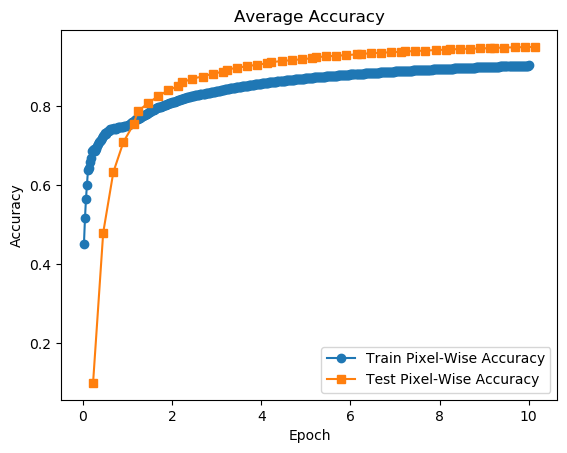

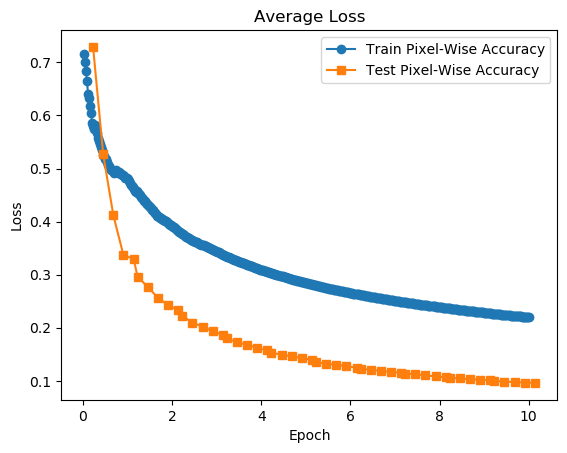

In [ ]:
plt.plot(total_updater.train_epoch, total_updater.train_avr_acc, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_acc, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy')

plt.legend()
plt.show()


plt.plot(total_updater.train_epoch, total_updater.train_avr_loss, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_loss, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss')

plt.legend()
plt.show()

Accuracy Scores

In [ ]:
print('average sample test accuracy per epoch')
total_updater.test_avr_acc_epoch

average sample test accuracy per epoch


[0.7536514282226563,
 0.9481437683105469,
 0.9584698016826924,
 0.9729671478271484,
 0.9720169067382812,
 0.9790098630464994,
 0.9773086547851563,
 0.9803386101355919,
 0.976926040649414,
 0.9779205322265625]

In [ ]:
final_test_batch_iterator = iter(testLoader)
batch_accuracies = []
tn_count = 0
fp_count = 0
fn_count = 0
tp_count = 0

while True:
    try:
        # model.eval()
        next_test_batch = next(final_test_batch_iterator)
        
        test_pixel_values = next_test_batch[0].to(device)
        test_labels = next_test_batch[1].to(device)
        test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
        test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
        test_predicted = test_upsampled_logits.argmax(dim=1)
        test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
        test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
        test_true_labels = test_labels[test_mask].detach().cpu().numpy()
        
        test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
        batch_accuracies.append(test_accuracy)

        conf_matrix = confusion_matrix(test_pred_labels, test_true_labels)
        tn, fp, fn, tp = conf_matrix.ravel()
        tn_count += tn
        fp_count += fp
        fn_count += fn
        tp_count += tp



    except StopIteration:
        break

iou = tp_count/(tp_count+fp_count+fn_count)
iou0 = tn_count/(tn_count+fn_count+fp_count)

print(f'pixel-wise accuracy: {sum(batch_accuracies)/len(batch_accuracies)}')
print(f'TN: {tn_count}, FP: {fp_count}, FN: {fn_count}, TP: {tp_count}')
print(f'precision: {tp_count/(tp_count+fp_count)}')
print(f'recall: {tp_count/(tp_count+fn_count)}')
print(f'iou (1 class): {iou}')
print(f'iou (0 class): {iou0}')
print(f'miou: {0.5*(iou+iou0)}')

pixel-wise accuracy: 0.9778480191202559
TN: 5954364, FP: 54829, FN: 95214, TP: 613033
precision: 0.9179036986682878
recall: 0.865563849899823
iou (1 class): 0.803370830690521
iou (0 class): 0.975420544534465
miou: 0.889395687612493


Hugging Face Upload

In [ ]:
#model.save_pretrained("segformer-b3-finetuned-mangrove-128-128-15p") #save weights to folder

In [ ]:
# model.save_model("./my_model")

# with open('auth_token.txt', 'r') as file:
#     auth_token = file.read().strip()

# model.save_model("mpham8/segformer-b5-finetuned-mangrove-128-128", use_auth_token=auth_token)

Inference

In [ ]:
model.eval()
next_test_batch = next(test_batch)
test_pixel_values = next_test_batch[0].to(device)
test_labels = next_test_batch[1].to(device)
test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
test_predicted = test_upsampled_logits.argmax(dim=1)
test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
test_true_labels = test_labels[test_mask].detach().cpu().numpy()
test_accuracy = accuracy_score(test_pred_labels, test_true_labels)

In [ ]:
reshaped_true = test_true_labels.reshape(BATCH_SIZE, INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)
reshaped_pred = test_pred_labels.reshape(BATCH_SIZE, INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)
rgb_pixels = test_pixel_values.detach().cpu().numpy()[:, 0:3,:,:]
rgb_pixels = rearrange(rgb_pixels, "b c w h -> b w h c")/np.max(rgb_pixels)

satellite image (3 bands only)


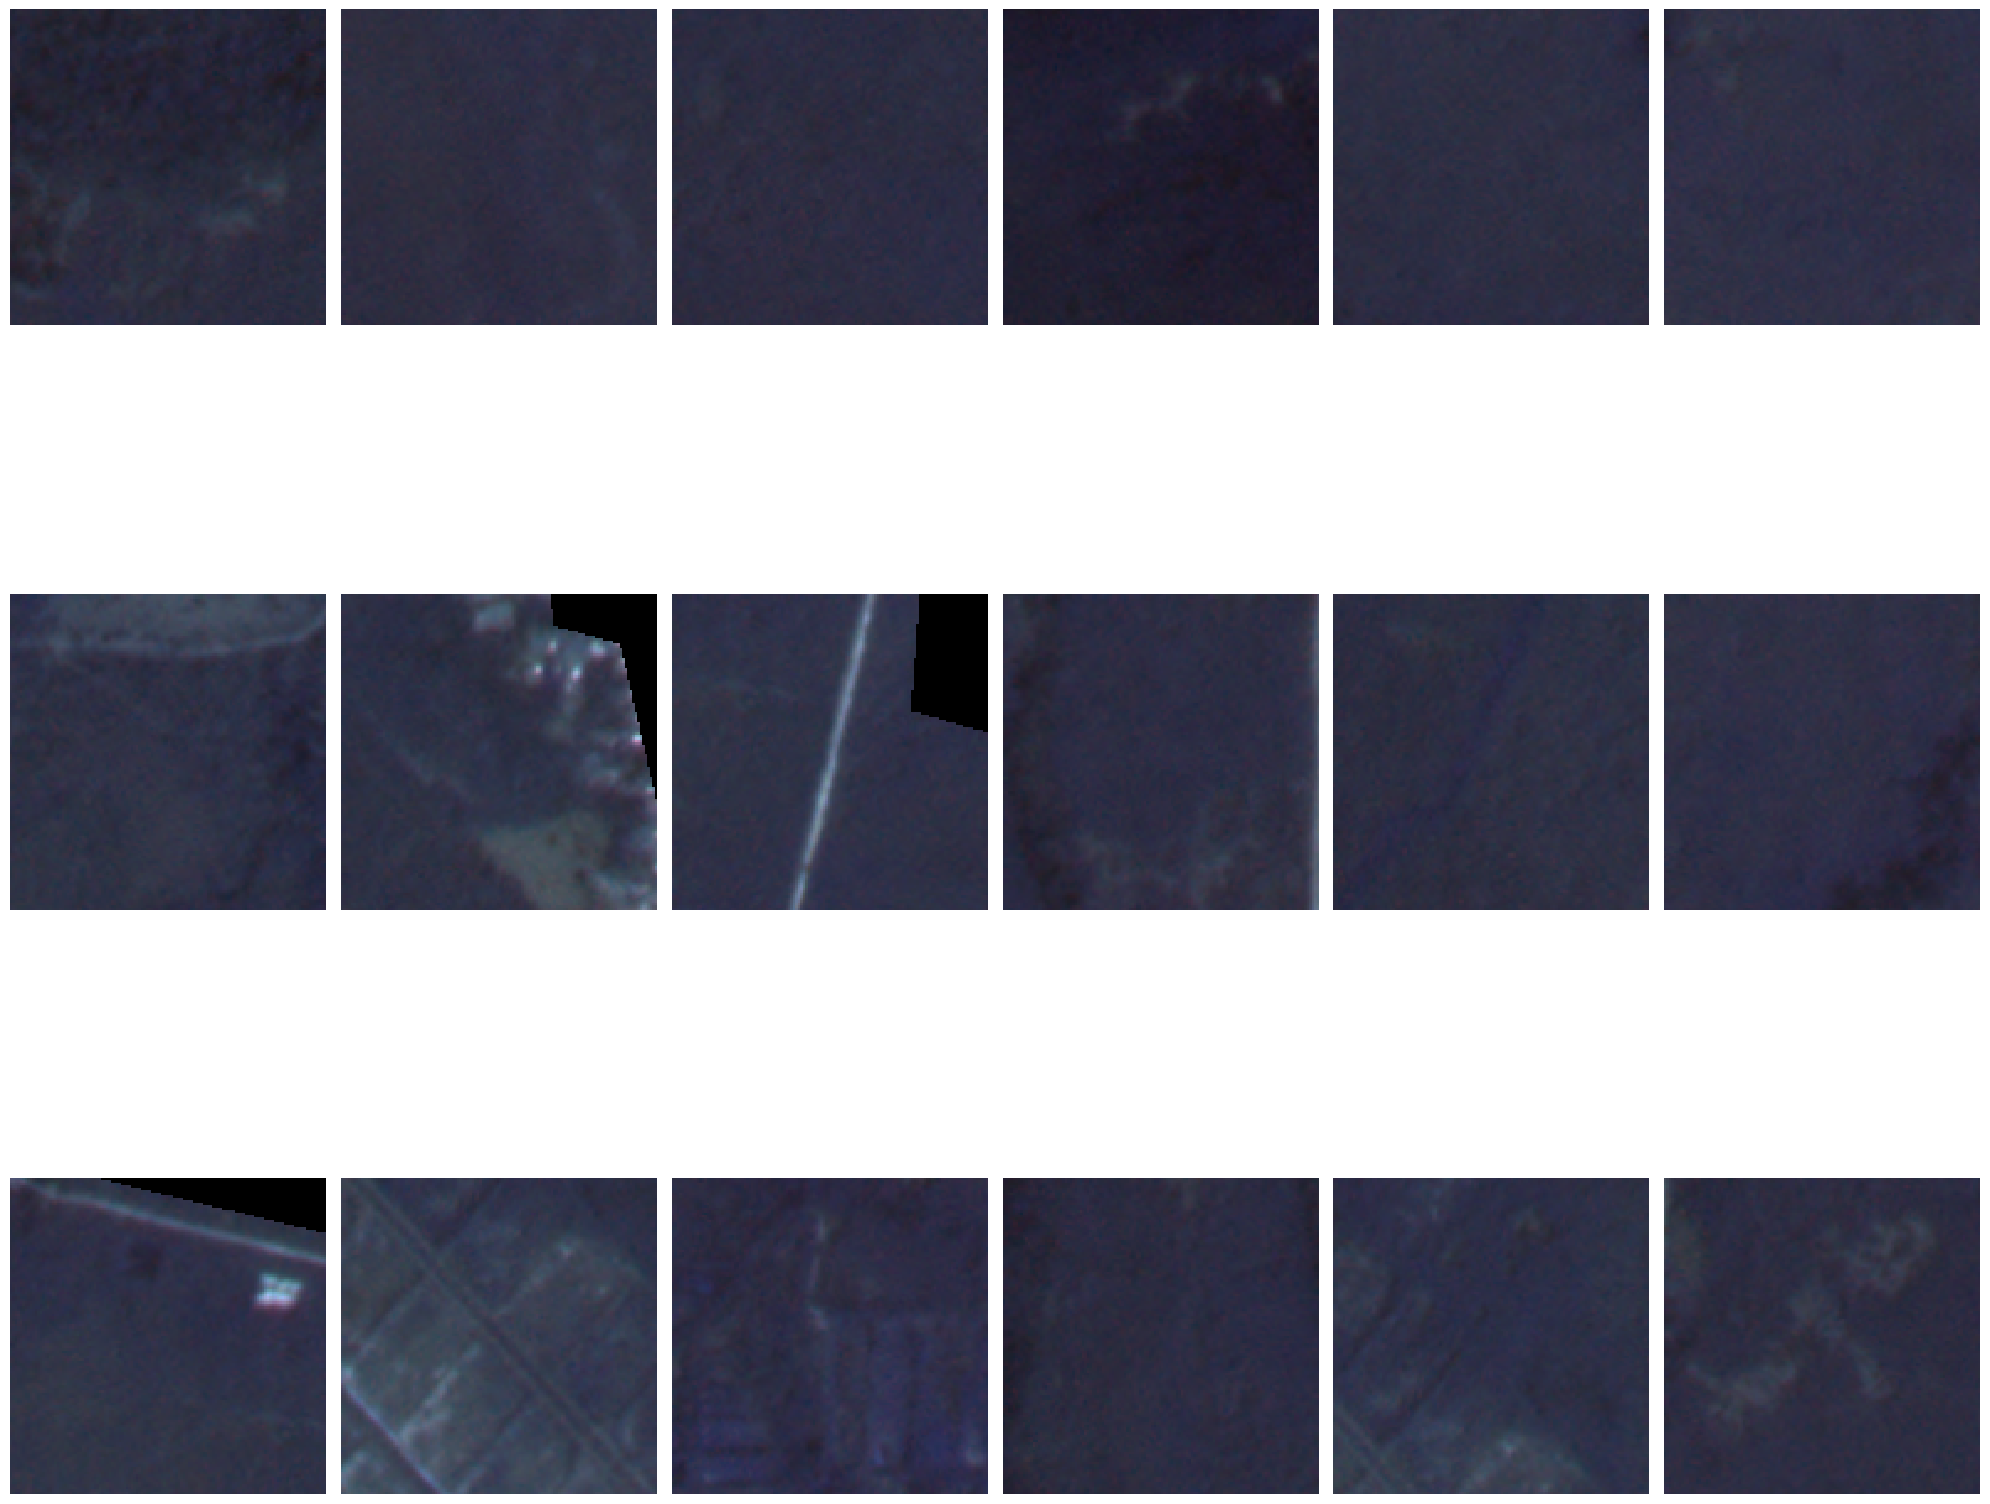

satellite image with predicted mask


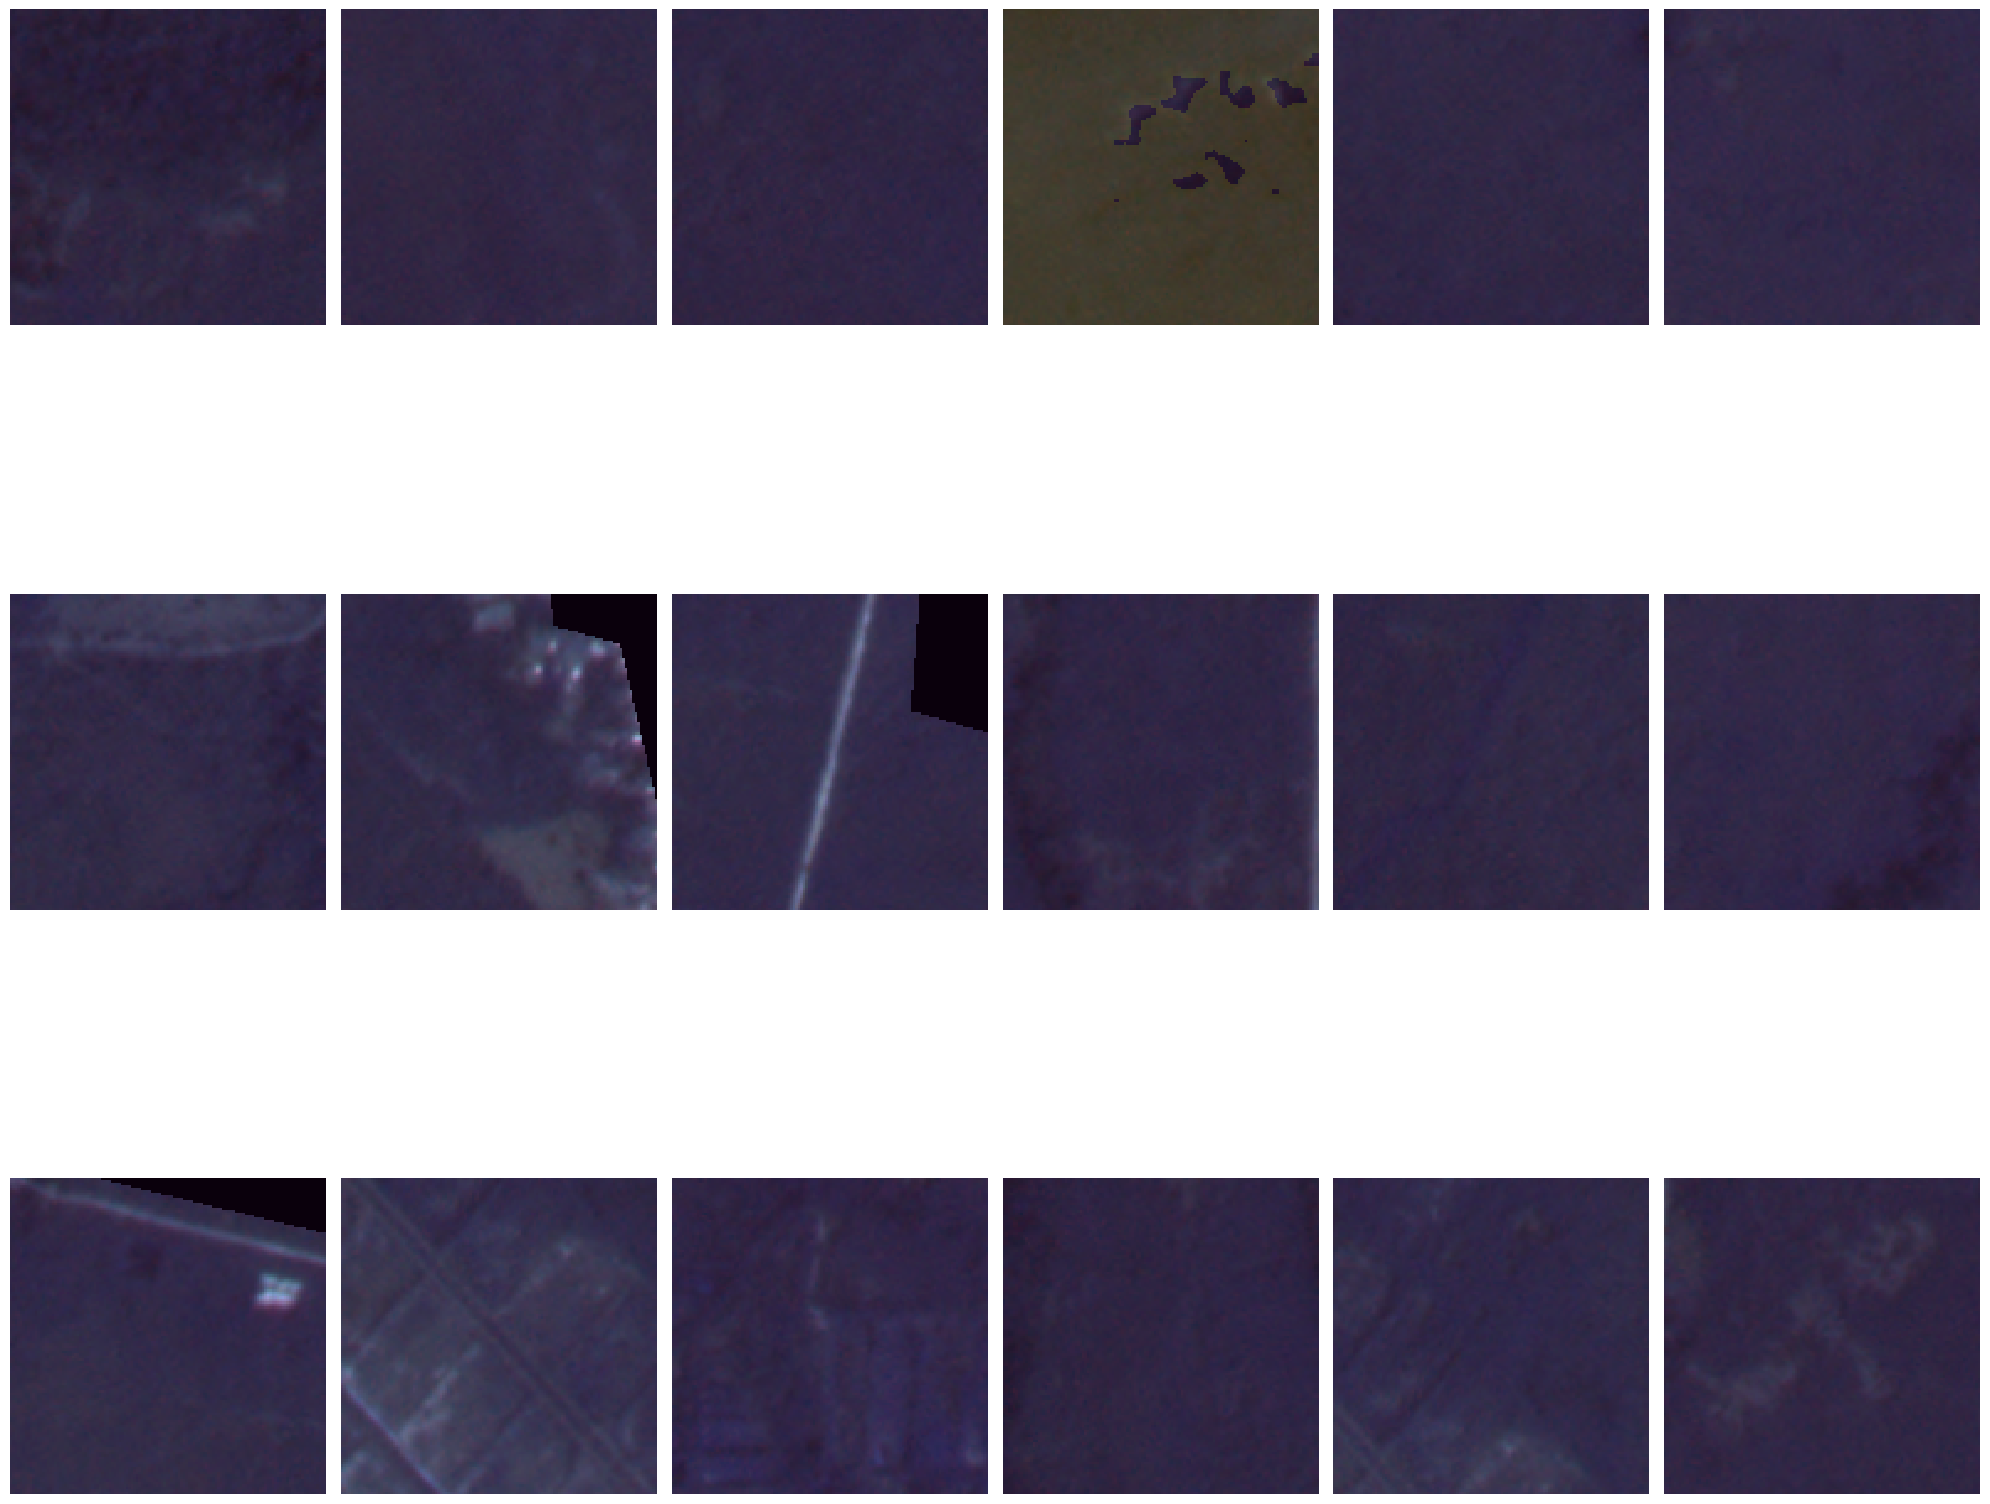

satellite image with true mask


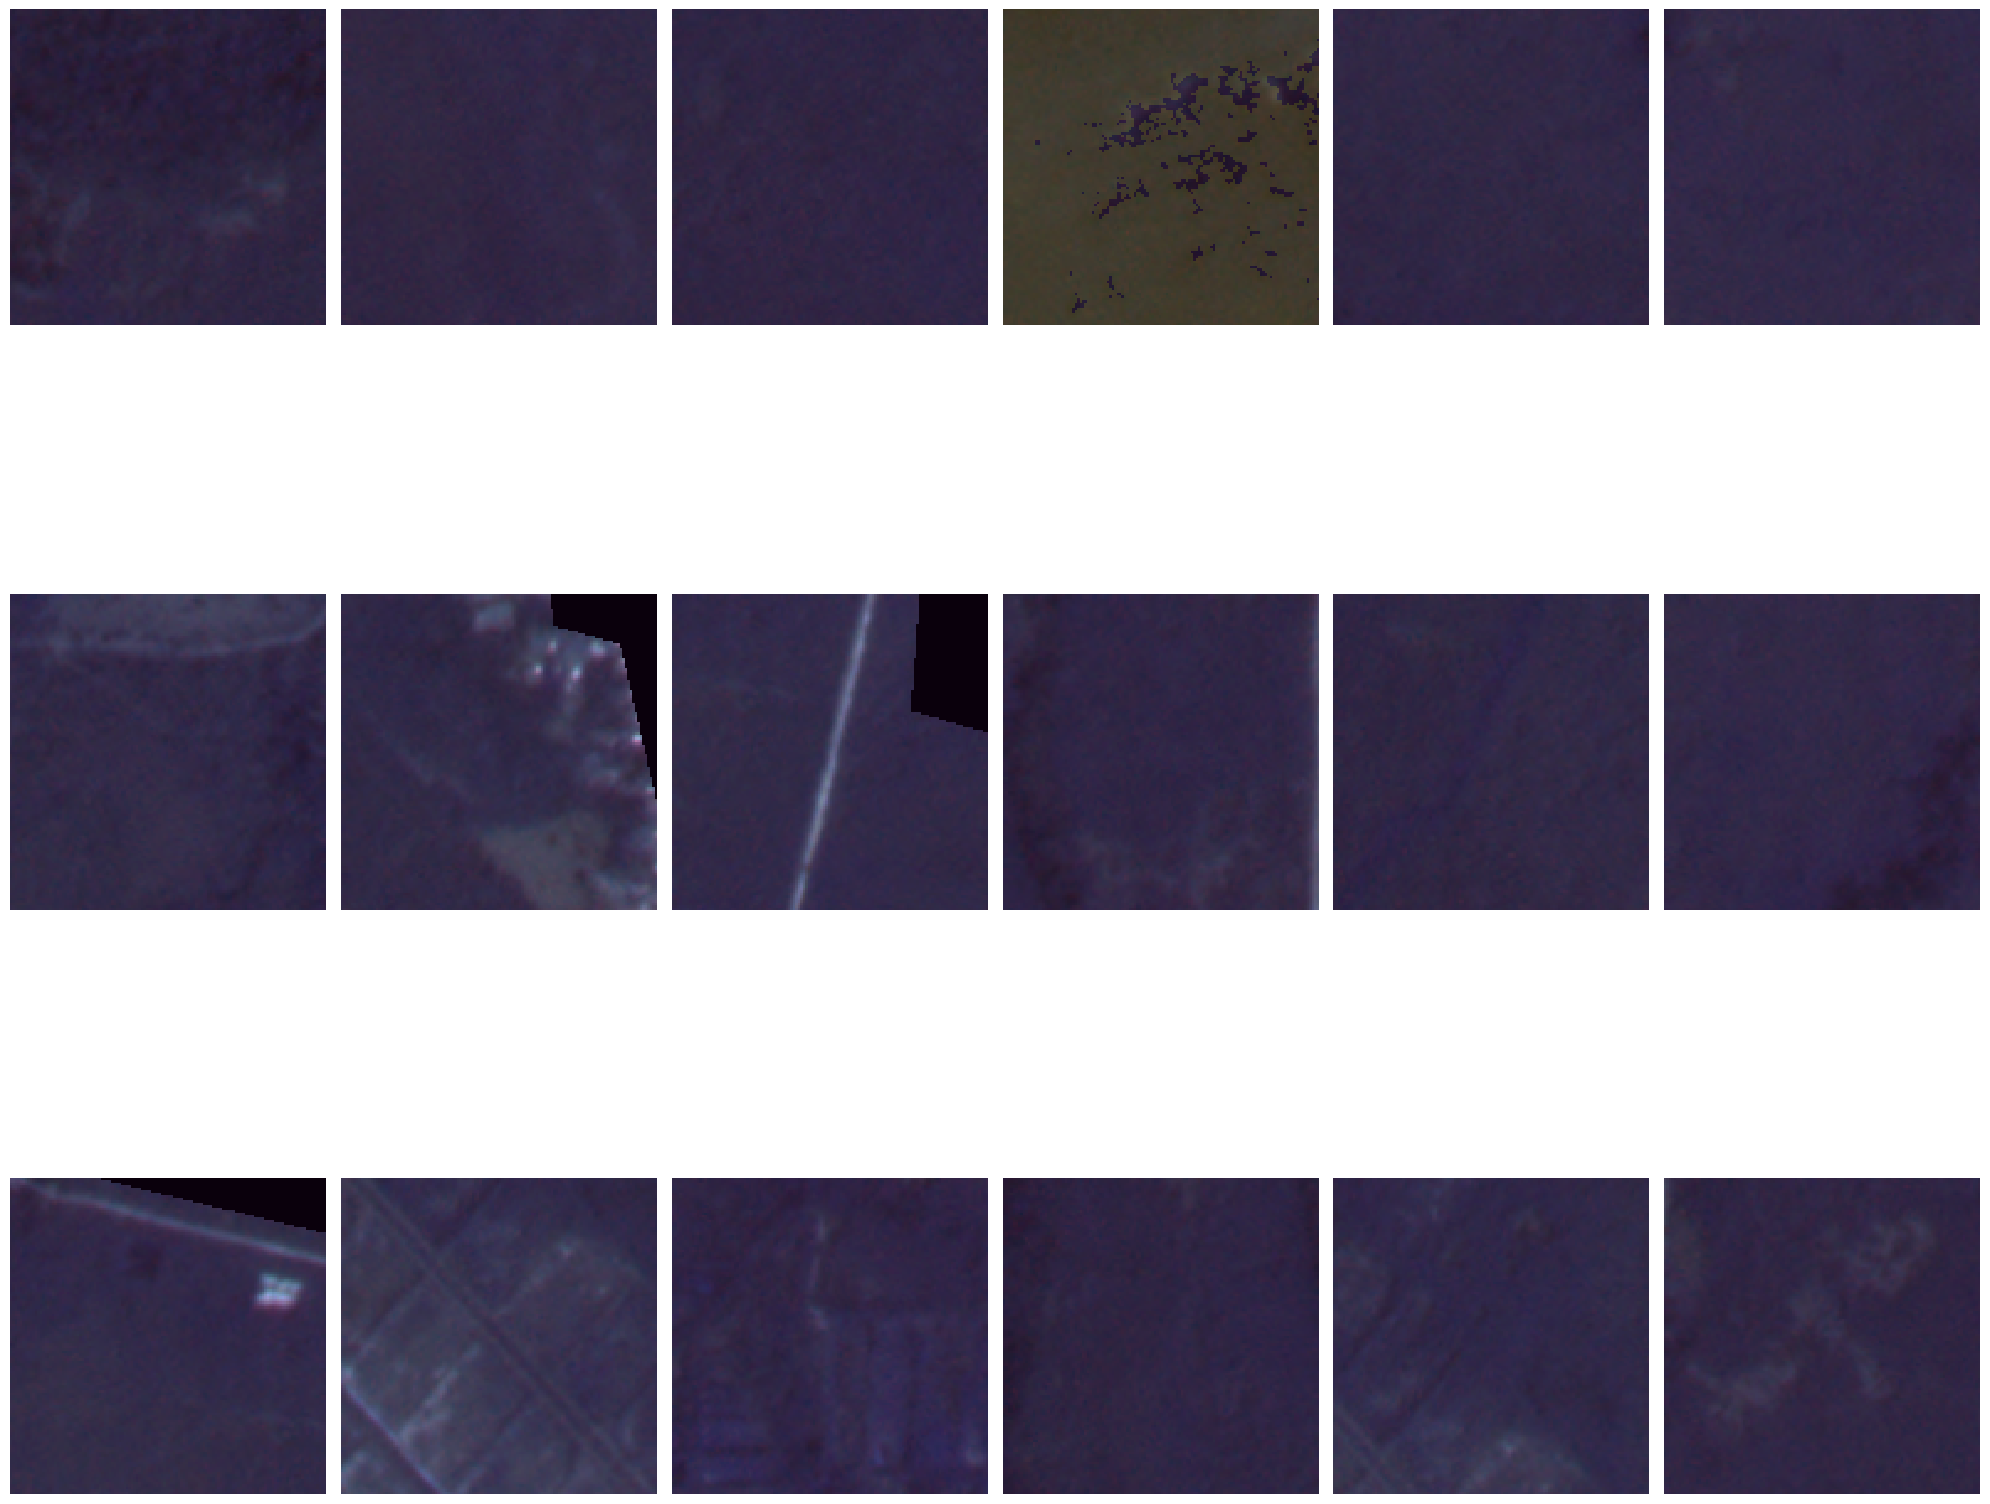

In [ ]:
num_rows = 3
num_cols = 6

print('satellite image (3 bands only)')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(num_rows*num_cols):
    img = rgb_pixels[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()



print('satellite image with predicted mask')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(num_rows*num_cols):
    img = rgb_pixels[i]
    mask = reshaped_pred[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Overlay the mask on the image with transparency (alpha value)
    # If the mask is binary (0 and 1), you can set alpha=0.5 to make the mask semi-transparent
    axes[i // num_cols, i % num_cols].imshow(mask, alpha=0.15, cmap='viridis')

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()


print('satellite image with true mask')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(num_rows*num_cols):
    img = rgb_pixels[i]
    mask = reshaped_true[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Overlay the mask on the image with transparency (alpha value)
    # If the mask is binary (0 and 1), you can set alpha=0.5 to make the mask semi-transparent
    axes[i // num_cols, i % num_cols].imshow(mask, alpha=0.15, cmap='viridis')

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()